### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

from YearPlotter import YearPlotter
import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBSSBB'
from pickle import load

#read statistics
filename=data_dir+'/STAT2_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['LTOBS', 'UTOBS']
12884
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[20 50 40 4C 80 4...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[00 00 A0 D3 00 0...|1927.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[80 4D 80 D4 E0 D...|1928.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[00 53 00 00 00 C...|1929.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     2|[E0 54 E0 55 00 4...|1930.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only 

### Select data for a particular station and measurement type

In [2]:
# Filtering through to see which station to use
sqlContext.registerDataFrameAsTable(df,'weather')

Query="SELECT station,count(distinct year), sum(undefs) as undefs "\
      "FROM weather "\
      "where elevation > 300 "\
      "group by station having sum(undefs) < 1000 "\
      "and count(distinct year)>50 "\
      "and count(distinct measurement) = 6 "\
      "order by undefs"
        
print Query
df1 = sqlContext.sql(Query)
print df1.show()

SELECT station,count(distinct year), sum(undefs) as undefs FROM weather where elevation > 300 group by station having sum(undefs) < 1000 and count(distinct year)>50 and count(distinct measurement) = 6 order by undefs
+-----------+--------------------+------+
|    station|count(DISTINCT year)|undefs|
+-----------+--------------------+------+
|USC00303851|                  87|   737|
+-----------+--------------------+------+

None


In [3]:
# Let's pick a station for our study
ustation = 'USC00303851' # HIGHMARKET

sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS',ustation)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
UO=np.vstack(rows)
UO=UO/10.  # scaling to make the temperature be in centingrates
shape(UO)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00303851'
2 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    537.4| 43.5753| -75.5208|       TOBS|USC00303851|    16|[E0 50 80 C9 90 D...|2011.0|BBBBSSBB|
|    537.4| 43.5753| -75.5208|       TOBS|USC00303851|    10|[00 00 20 D0 00 7...|2012.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+



(2, 365)

In [4]:
# let's get TOBS for lower elevation
lstation = 'USC00306314' # Oswego

Query="SELECT * FROM weather "\
      "WHERE measurement='%s' and station='%s'"%('TOBS',lstation)

df2 = sqlContext.sql(Query)
print df2.count(),'rows'
df2.show(2)
rows=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
LO=np.vstack(rows)
LO=LO/10.  # scaling to make the temperature be in centigrades
shape(LO)

43 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       TOBS|USC00306314|     1|[E0 D5 00 D3 00 D...|1969.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TOBS|USC00306314|     1|[40 D6 E0 D4 30 D...|1970.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(43, 365)

### Script for plotting yearly plots

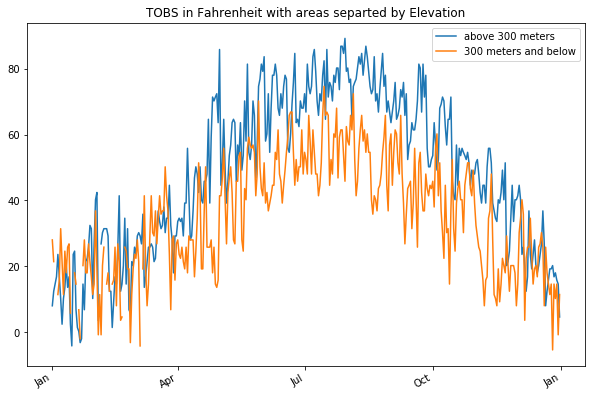

In [7]:
# lower 300 elevation and upper 300 elevation of TOBS
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(LO[1:2,:].transpose()*2-4+32,fig,ax,labels=['above 300 meters '])
YP.plot(UO[1:2,:].transpose()*2-4+32,fig,ax,labels=['300 meters and below'],
        title='TOBS in Fahrenheit with areas separted by Elevation')

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [8]:
def plot_pair(pair,func,c=0,labels=None):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis,c,labels)
        
def plot_valid(m,fig,axis,c,labels=None):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title=m+' valid-counts',label=labels)

### Plots of mean and std of observations

In [9]:
STAT['UTOBS']

{'Cov': array([[ 2941.24196441,   654.70619976,    98.72019074, ...,
           -44.88117908,    17.06429787,   -63.26440985],
        [  654.70619976,  2568.65451981,   996.97902896, ...,
           -88.02087357,   -72.64157337,    23.85962368],
        [   98.72019074,   996.97902896,  2901.69042969, ...,
            52.19173644,   304.64202892,    66.7730492 ],
        ..., 
        [  -44.88117908,   -88.02087357,    52.19173644, ...,
          3233.20958261,   873.9364765 ,   414.46337073],
        [   17.06429787,   -72.64157337,   304.64202892, ...,
           873.9364765 ,  2973.40168263,  1035.42076064],
        [  -63.26440985,    23.85962368,    66.7730492 , ...,
           414.46337073,  1035.42076064,  3273.26866633]]),
 'E': array([ -28820.,  -29194.,  -26928.,  -28201.,  -30578.,  -29547.,
         -31275.,  -30575.,  -33965.,  -30804.,  -32838.,  -32541.,
         -33075.,  -29467.,  -27708.,  -31431.,  -29410.,  -26022.,
         -28870.,  -33547.,  -29867.,  -27544., 

In [10]:
def plot_mean_std(m,fig,axis,c,labels=None):
    mean=STAT[m]['Mean']/10.*2-4+32
    std=np.sqrt(STAT[m]['Var'])/10.*2-4+32

    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title=m+' Mean+-std',labels=labels)

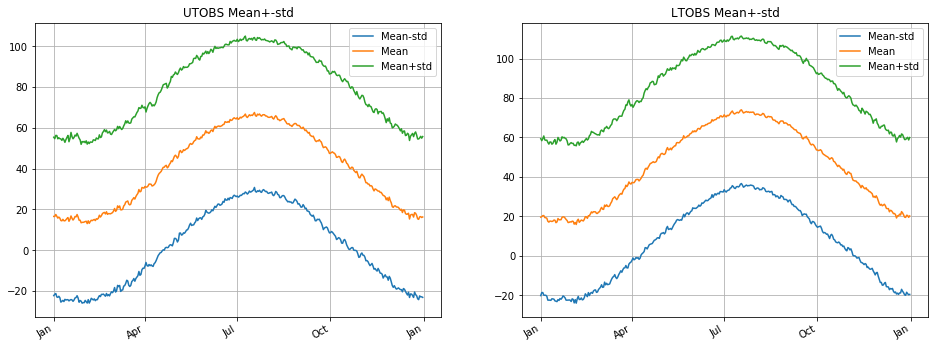

In [11]:
plot_pair(['UTOBS','LTOBS'],plot_mean_std,0,['Mean-std','Mean','Mean+std'])

In [12]:
def plot_mean(m,fig,axis,label):
    mean=STAT[m]['Mean']/10.0*2-4+32
    YP.plot(mean,fig,axis,title=m+' Mean',label=label)

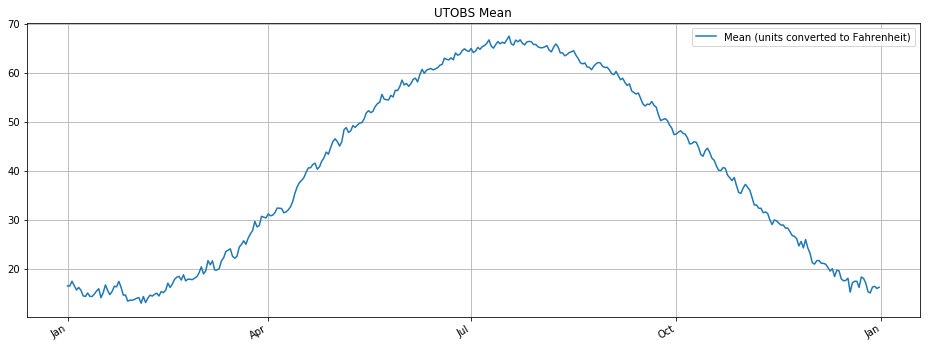

In [15]:
fig,X=subplots(1,1,figsize=(16,6))
plot_mean('UTOBS',fig,X,'Mean (units converted to Fahrenheit)')

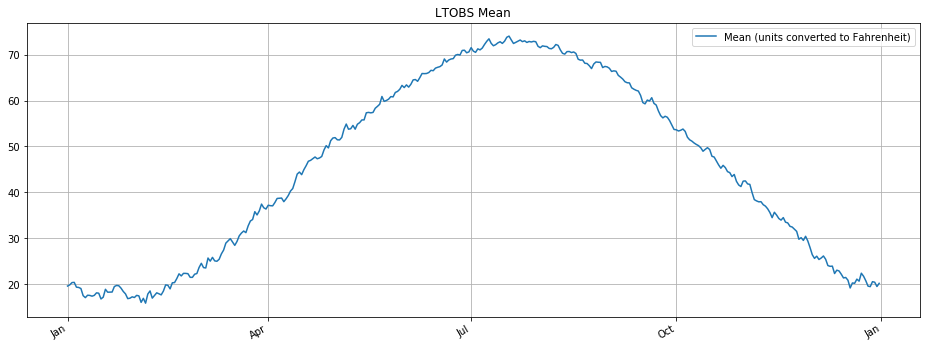

In [17]:
fig,X=subplots(1,1,figsize=(16,6))
plot_mean('LTOBS',fig,X,'Mean (units converted to Fahrenheit)')

#### plotting top 3 eigenvectors

In [18]:
def plot_eigen(m,fig,axis,c=3,labels=None):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:c],fig,axis,title=m+' Top Eigenvectors',labels=labels)

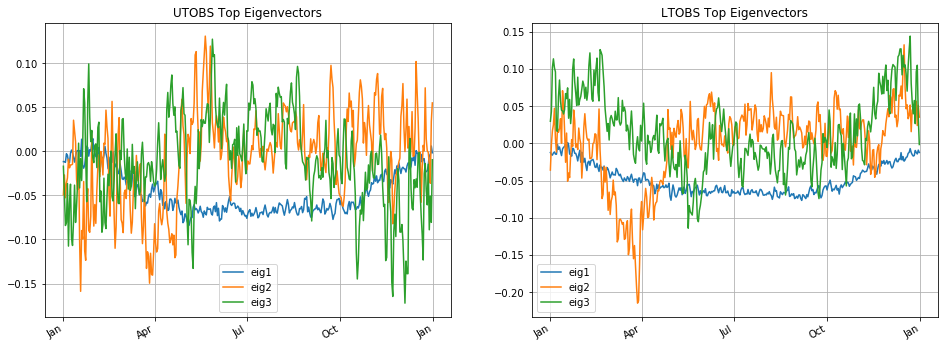

In [19]:
plot_pair(['UTOBS','LTOBS'],plot_eigen,3,['eig1','eig2','eig3'])

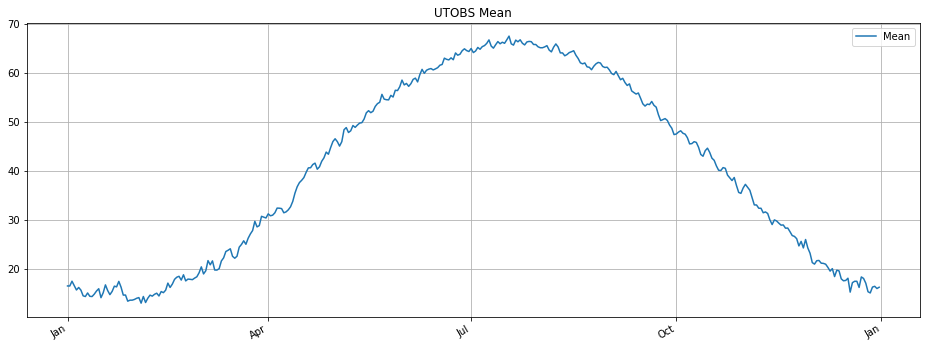

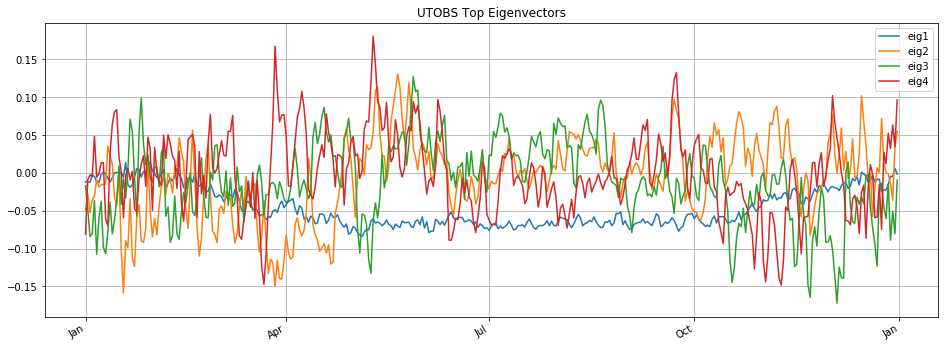

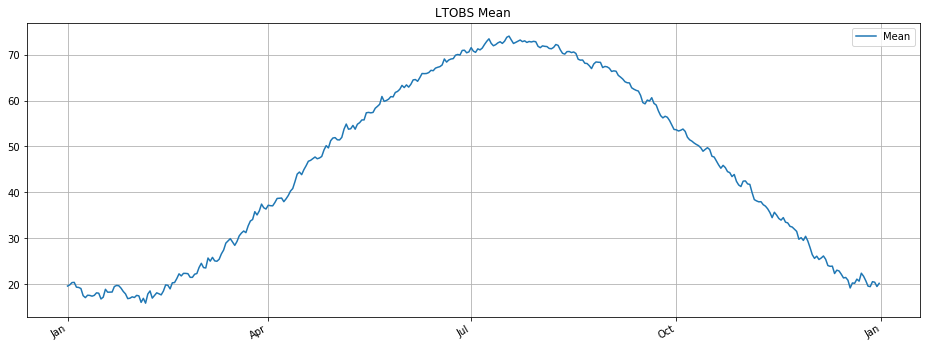

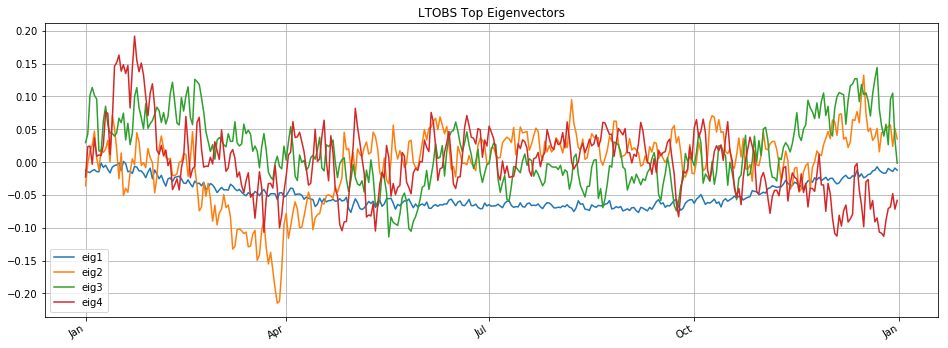

In [20]:
tobs = ('UTOBS','LTOBS')

for o in tobs:
    fig,X=subplots(1,1,figsize=(16,6))
    plot_mean(o,fig,X,'Mean')
    fig,X=subplots(1,1,figsize=(16,6))
    plot_eigen(o,fig,X,4,['eig1','eig2','eig3','eig4'])

### Script for plotting percentage of variance explained

In [21]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

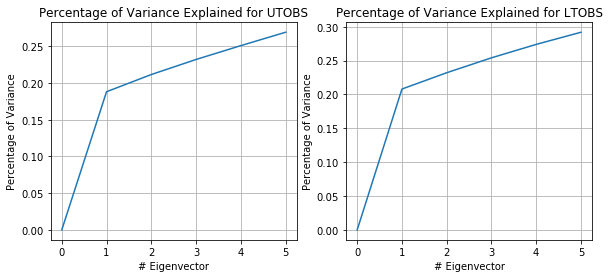

In [22]:
f=plt.figure(figsize=(15,4))
j=1
for m in tobs:
    pltVarExplained(j)
    j+=1

In [ ]:
#sc.stop()